In [210]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
y_train = tf.one_hot(y_train, depth=10).numpy()
y_test = tf.one_hot(y_test, depth=10).numpy()

In [211]:
# mnist画像直列化
x_train, x_test = x_train.reshape(x_train.shape[0], -1), x_test.reshape(x_test.shape[0], -1)

In [212]:
x_test.shape

(10000, 784)

In [187]:
# 元の画像を10個のラベル事に整理
nte = 500
test_high = []
for i in range(10):
    idx = np.where(y_test[:, i] == 1)[0]
    test_high.append(x_test[idx[-nte:], :])
test_high = np.array(test.high)
print(test_high.shape)

(10, 500, 784)


In [213]:
# ガウスカーネル
size=9
s=1.3
width = int(size//2)
a = np.abs(np.arange(-width, width+1)[:, np.newaxis])
dist = a**2 + (a**2).T
kernel = np.exp(-dist / (2 * s**2)) / (2 * np.pi * s)

In [215]:
from scipy.signal import fftconvolve
test_low = []
# 低解像度の画像の準備
for i in range(test_high.shape[0]):
    blured_imgs_per_label = []
    for j in range(test_high.shape[1]):
        high_img = test_high[i, j].reshape(28, 28)
        blured_img = fftconvolve(high_img, kernel, mode='same')
        blured_imgs_per_label.append(blured_img.flatten())
    test_low.append(blured_imgs_per_label)
test_low = np.array(test_low)
print(test_low.shape)

(10, 500, 784)


In [216]:
A = np.zeros((784, 784))
c = 0
for i in range(28):
    for j in range(28):
        a = np.zeros((28+2*width, 28+2*width))
        for k in range(2*width+1):
            a[i+k, j:j+(2*width+1)] = kernel[k, :]
        A[c, :] = a[width:-width, :][:, width:-width].flatten()
        c += 1

### ISTA
$ \hat{x} = {\rm argmin} \frac{1}{2} \| b - Ax\| + \lambda \| x \|_1$  
$ g_t = A^T (A x_{t -1} - b)$  
$ x_t = S_{\eta \lambda}(x_{t - 1} - \eta g_t) = S_{\eta \lambda} ((I - A^T A ) x_{t -1} + A^T A b)$

In [197]:
def ista(kernel, x, rho=0.1, max_iter=500, tol=1e-5):
    d = A.shape[1]
    m = A.shape[0]
    rho *= m
    s = np.linalg.svd(A, full_matrices=False, compute_uv=False)
    # 最急勾配が大域解の近傍で収束する必要条件を満たすようにステップサイズを決定
    eta = 1 / np.max(s**2)
    z = np.zeros(d)
    obj = 0.5 * np.sum((A.dot(z) - x)**2) + rho * np.sum(np.abs(z))
    for itr in range(max_iter):
        gi = A.T.dot(A.dot(z) - x)
        zi = z - eta * gi
        # 近接作用素
        z_new = np.sign(zi) * np.maximum(0.0, np.abs(zi) - rho * eta)
        z_new = np.maximum(0.0, z_new)
        obj_new = 0.5 * np.sum((A.dot(z_new) - x)**2) + rho * np.sum(np.abs(z_new))
        if obj - obj_new < tol:
            break
        z = z_new
        obj = obj_new
    return z

In [217]:
def recover(low_imgs, A, rho=1e-2):
    recovered = []
    for i in range(low_imgs.shape[0]):
        print(i)
        yi = []
        for j in range(low_imgs.shape[1]):
            yij = ista(A, low_imgs[i, j, :], rho=rho, max_iter=500)
            yi.append(yij)
        recovered.append(yi)
    return np.array(recovered)

In [218]:
recovered_imgs = recover(test_low, A, rho=rho)
print(recovered_imgs.shape)

0
1
2
3
4
5
6
7
8
9
(10, 500, 784)


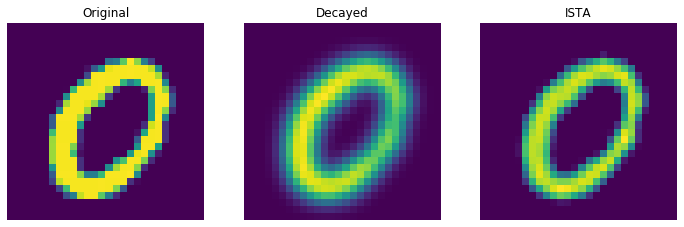

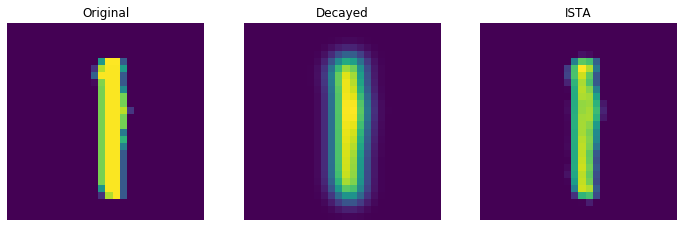

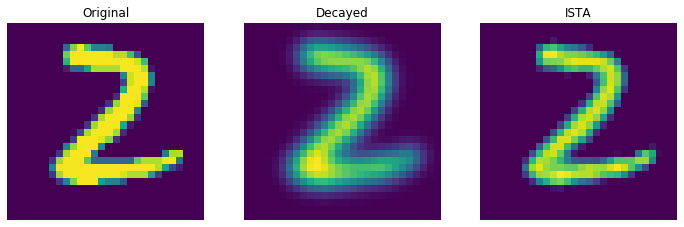

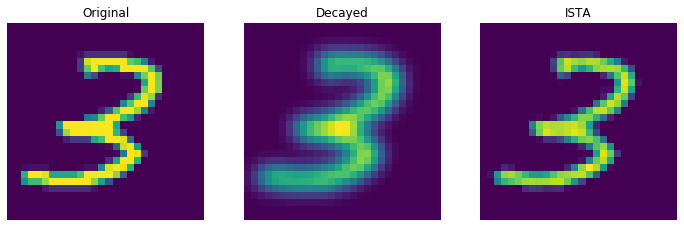

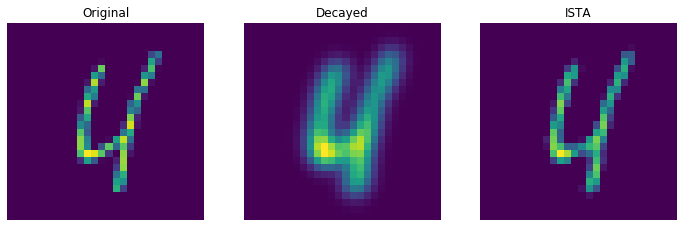

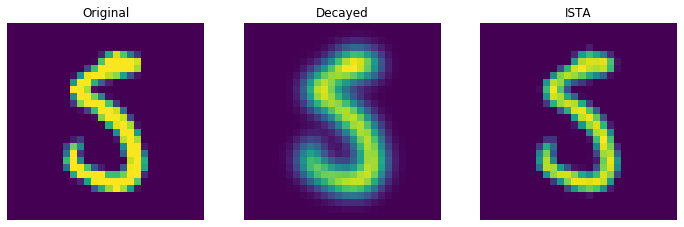

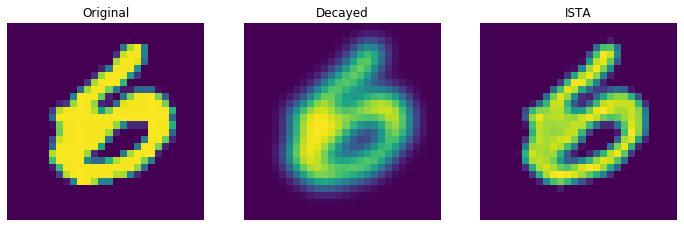

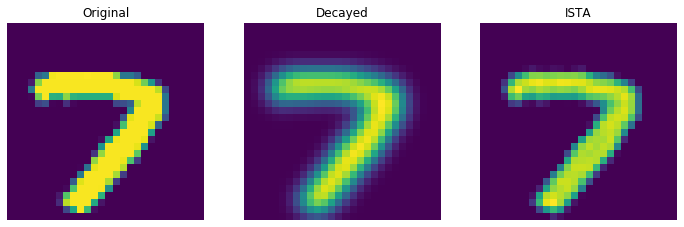

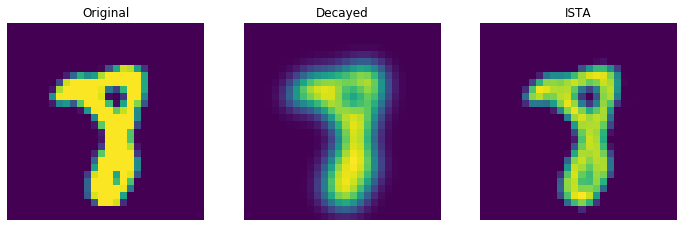

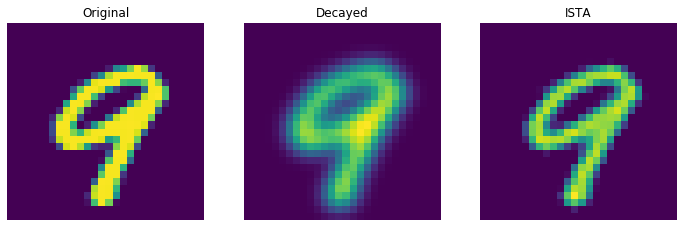

In [220]:
from matplotlib import pyplot as plt
# examples of recovered images
j = 12
for i in range(recovered_imgs.shape[0]):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(test_high[i, j, :].reshape((28, 28)))
    plt.title('Original')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(test_low[i, j, :].reshape((28, 28)))
    plt.title('Decayed')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(recovered_imgs[i, j, :].reshape((28, 28)))
    plt.title('ISTA')
    plt.axis('off')
    plt.show()